Note: You should have prepare your env through going through the module-vosk.ipynb file. 

In [1]:
import os
import wave
import json
import time
import numpy as np
import soundfile as sf  # Install with: pip install soundfile
import sounddevice as sd
import matplotlib.pyplot as plt  # For plotting
from IPython.display import Audio
from vosk import Model, KaldiRecognizer, SpkModel
from scipy.io.wavfile import write
from pathlib import Path
PROJECT_ROOT = Path("/home/thaonan/Projects/Dormitory-Assistant")
%cd {PROJECT_ROOT}

SPK_MODEL_PATH = "model-spk"


/home/thaonan/Projects/Dormitory-Assistant


In [3]:
# 1. Record a wav file
fs = 16000  # Sample rate
seconds = 5  # Duration

print("\n=== Voice Recording ===")
wav_file = input("Enter name for WAV file (e.g., thn.wav): ").strip()
print(f"Will record for {seconds} seconds (16kHz mono)")
print("Please get ready...\n")

# 3-second countdown
for i in range(3, 0, -1):
    print(f"Starting in {i}...", end='\r')
    time.sleep(1)

print("Recording NOW!      ")

# Start recording
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1, dtype='int16')

# Progress indicator during recording
for t in range(seconds):
    print(f"Recording... {t+1}/{seconds} seconds", end='\r')
    time.sleep(1)

sd.wait()  # Ensure recording completes
print("\nRecording complete!")

# Save as WAV
# Ensure it ends with .wav
if not wav_file.lower().endswith('.wav'):
    wav_file += '.wav'

# Save the recording
write(wav_file, fs, recording)
print(f"Recording saved as: {wav_file}")


# Verify the WAV format
with wave.open(wav_file, 'rb') as wf:
    print(f"Channels: {wf.getnchannels()}")
    print(f"Sample width: {wf.getsampwidth()} bytes")
    print(f"Sample rate: {wf.getframerate()} Hz")
    print(f"Duration: {wf.getnframes() / wf.getframerate():.2f} seconds")

# force-fixed
!ffmpeg -y -i {wav_file} -acodec pcm_s16le -ac 1 -ar 16000 {wav_file}
# Verify the WAV format
with wave.open(wav_file, 'rb') as wf:
    print(f"Channels: {wf.getnchannels()}")
    print(f"Sample width: {wf.getsampwidth()} bytes")
    print(f"Sample rate: {wf.getframerate()} Hz")
    print(f"Duration: {wf.getnframes() / wf.getframerate():.2f} seconds")



=== Voice Recording ===


Will record for 5 seconds (16kHz mono)
Please get ready...

Recording NOW!      
Recording... 5/5 seconds
Recording complete!
Recording saved as: jlz.wav
Channels: 1
Sample width: 2 bytes
Sample rate: 16000 Hz
Duration: 5.00 seconds
ffmpeg version 5.1.6-0+deb12u1+rpt1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1+rpt1 --toolchain=hardened --incdir=/usr/include/aarch64-linux-gnu --enable-gpl --disable-stripping --disable-mmal --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist 

In [4]:
# 2. Hear your soud
Audio(wav_file)  # Listen in notebook

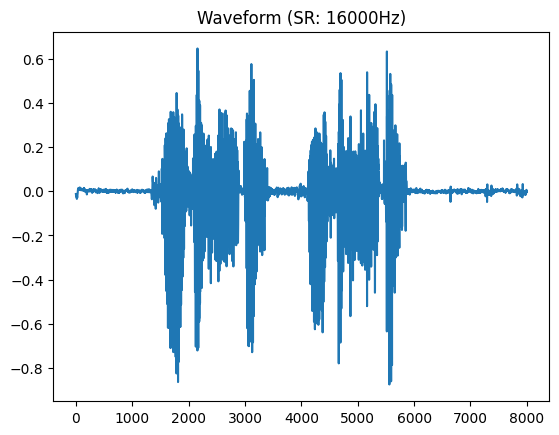

In [5]:
# 3. Visualize the wav file

# Read file
audio, sample_rate = sf.read(f"{wav_file}")  

# Plot (downsample for smoother visualization)
plt.plot(audio[::10])  
plt.title(f"Waveform (SR: {sample_rate}Hz)")
plt.show()

In [6]:
# 4. Extract Speaker voice-fingerprint (Speaker-Embedding or x-vector)

# load models
model = Model(lang="en-us")
spk_model = SpkModel(SPK_MODEL_PATH)
rec = KaldiRecognizer(model, wf.getframerate())
rec.SetSpkModel(spk_model)


with open(wav_file, 'rb') as f:
    audio_data = f.read()

if rec.AcceptWaveform(audio_data):
    result = json.loads(rec.Result())
    spk_sig = np.array(result['spk'])  # Convert to numpy array
    print("Speaker embedding extracted successfully!")
    print(f"X-vector shape: {spk_sig.shape}")  # Should be (512,)
else:
    print("Failed to extract speaker embedding")

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/thaonan/.cache/vosk/vosk-model-small-en-us-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from /home/thaonan/.cache/vosk/vosk-model-small-en-us-0.15/graph/HCLr.fst /home/thaonan/.cache/vosk/vosk-model-small-en-us-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo /home/thaonan/.cache/vosk/vosk-model-small-en-us-0.15/graph/phones/word_boundary.

Speaker embedding extracted successfully!
X-vector shape: (128,)


LOG (VoskAPI:~CachingOptimizingCompiler():nnet-optimize.cc:710) 0.0627 seconds taken in nnet3 compilation total (breakdown: 0.0545 compilation, 0.00207 optimization, 0 shortcut expansion, 0.000505 checking, 2.15e-06 computing indexes, 0.0056 misc.) + 0 I/O.


In [7]:
# 5. Save/Reuse Speaker Signature

name = os.path.splitext(os.path.basename(wav_file))[0]  # Extracts "thn" from "/path/to/thn.wav"

# Save signature (only if spk_sig exists)
if 'spk_sig' in globals():  # Checks if variable exists
    signature_file = f"{name}_signature.npy"
    np.save(signature_file, spk_sig)
    print(f"✓ Speaker signature saved as {signature_file}")
else:
    print("✗ No spk_sig variable found - run extraction first")

# Load signature (with error handling)
def load_signature(name):
    filename = f"{name}_signature.npy"
    try:
        loaded_sig = np.load(filename)
        print(f"✓ Loaded signature from {filename}")
        print(f"Shape: {loaded_sig.shape}, Norm: {np.linalg.norm(loaded_sig):.2f}")
        return loaded_sig
    except FileNotFoundError:
        print(f"✗ File {filename} not found")
        return None
    except Exception as e:
        print(f"✗ Error loading {filename}: {str(e)}")
        return None

# Usage example
loaded_sig = load_signature(name)  # Loads "thn_signature.npy"

✓ Speaker signature saved as jlz_signature.npy
✓ Loaded signature from jlz_signature.npy
Shape: (128,), Norm: 11.31


In [8]:
loaded_sig

array([-0.489516,  0.629069,  1.17883 ,  1.216751, -1.287663, -0.607898,
        0.586289,  0.142893,  1.171437,  0.389016, -0.133497,  1.172889,
       -0.161589, -1.342145, -0.527814,  0.392424,  0.827719, -0.672783,
       -0.089601, -0.998248,  0.884139,  0.443017, -0.008385, -0.147291,
       -1.461402,  0.664128,  2.413828, -2.256588,  0.217719,  0.162029,
       -0.181231, -1.851549,  0.864038, -0.630362, -0.224302,  0.763184,
       -0.145577, -0.880064,  0.930674, -0.375777, -0.754038, -0.247887,
       -0.095985, -2.445989,  1.037192,  0.978052, -0.139364, -0.399454,
       -0.228997, -0.196082, -0.238875,  0.024238,  0.645456, -0.409753,
        1.638496, -0.769128, -0.153408,  0.609655,  0.680227, -1.025789,
        0.593034,  0.254534, -0.368667, -0.496608, -0.266626, -1.377601,
       -0.087174,  2.296747, -1.565368, -0.053137, -0.238565, -1.240842,
       -3.21333 ,  0.068302, -0.429467,  0.659034, -1.86749 ,  0.450685,
        0.911886,  1.192028,  0.33154 , -1.379321, 